In [1]:
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport Compute_Jacobian_Sioux

In [2]:
numNodes = Compute_Jacobian_Sioux.numNodes;
numLinks = Compute_Jacobian_Sioux.numLinks;
numZones = Compute_Jacobian_Sioux.numZones;
numODpairs = Compute_Jacobian_Sioux.numODpairs;
od_pairs = Compute_Jacobian_Sioux.od_pairs;
link_list_js = Compute_Jacobian_Sioux.link_list_js;
link_length_list = Compute_Jacobian_Sioux.link_length_list;

In [3]:
include("initia_data.jl");
include("prepare_data_Sioux.jl");
include("extract_data_Sioux.jl");
include("../Julia_files/tap_MSA.jl");
include("../Julia_files/inverseVI.jl");
include("../Julia_files/demands_adjustment_gradi.jl");

In [4]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
                     norm(demandsDicToVec(demandsDict[0]));

In [5]:
fcoeffs = [1, 0, 0, 0, .15];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [6]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("./benchmark_data/Sioux_net.txt", tapFlowDicDict[0]);

In [7]:
deg = 6
c = 3.41
lam = 1.

# coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);
coeffs_dict[(deg, c, lam, 1)] = fcoeffs;
objInvVIDict[1] = 0;

In [8]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [9]:
demandsVecDict[1] = demandsDicToVec(demandsDict[1]);
objFunDict[1] = objF(demandsVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [10]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("./benchmark_data/Sioux_net.txt", tapFlowDicDict[1]);

In [11]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [12]:
linkCostDicDict[1]["0"], link_length_list[1]

(6.001099860406928,6.0)

In [13]:
jacobiSpiessDict[1] = Compute_Jacobian_Sioux.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[1]["$(i)"] for i=0:numLinks-1]);

In [14]:
# maximum number of iterations
N = 50;  

# Armijo rule parameters
rho = 2;
M = 10;

# search direction parameter
epsilon_1 = 0;

# stop criterion parameter
epsilon_2 = 1e-20;

In [15]:
for l = 1:N
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], epsilon_1);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(objFunDict[l], demandsVecDict[l], coeffs_dict[(deg, c, lam, l)], 
    searchDirecDict[l], thetaMaxDict[l], rho, M);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("./benchmark_data/Sioux_net.txt", tapFlowDicDict[l+1]);
        
#     coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[0]);
    coeffs_dict[(deg, c, lam, l+1)] = fcoeffs;
    objInvVIDict[l+1] = 0;

    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    jacobiSpiessDict[l+1] = Compute_Jacobian_Sioux.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[l+1]["$(i)"] for i=0:numLinks-1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
    
    # stopping criterion
    if (objFunDict[l] - objFunDict[l+1]) / objFunDict[1] < epsilon_2
        break
    end
        
end

# normalize objective function value
for l = 1:(length(objFunDict))
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [16]:
demandsVecDict

Dict{Any,Any} with 9 entries:
  0 => [100.0,100.0,500.0,200.0,300.0,500.0,800.0,500.0,1300.0,500.0  …  400.0,…
  4 => [87.6583,109.66,445.836,210.172,242.104,538.276,867.467,418.417,1430.5,5…
  7 => [76.423,111.918,449.323,209.365,229.467,530.999,859.698,410.925,1419.13,…
  2 => [92.6422,109.3,446.018,212.864,247.617,541.42,871.314,423.501,1436.21,51…
  3 => [91.2973,109.353,445.876,212.016,246.128,540.566,870.251,422.012,1434.57…
  5 => [84.4318,110.346,446.733,209.651,238.509,536.477,865.291,416.038,1427.34…
  8 => [76.423,111.918,449.323,209.365,229.467,530.999,859.698,410.925,1419.13,…
  6 => [82.2678,110.796,447.421,209.507,236.063,535.018,863.75,414.597,1425.14,…
  1 => [98.7226,108.564,444.608,220.179,255.035,544.795,875.241,440.222,1456.21…

In [17]:
norObjFunDict

Dict{Any,Any} with 8 entries:
  7 => 0.324786
  4 => 0.50372
  2 => 0.650412
  3 => 0.606409
  5 => 0.438469
  8 => 0.324786
  6 => 0.401194
  1 => 1.0

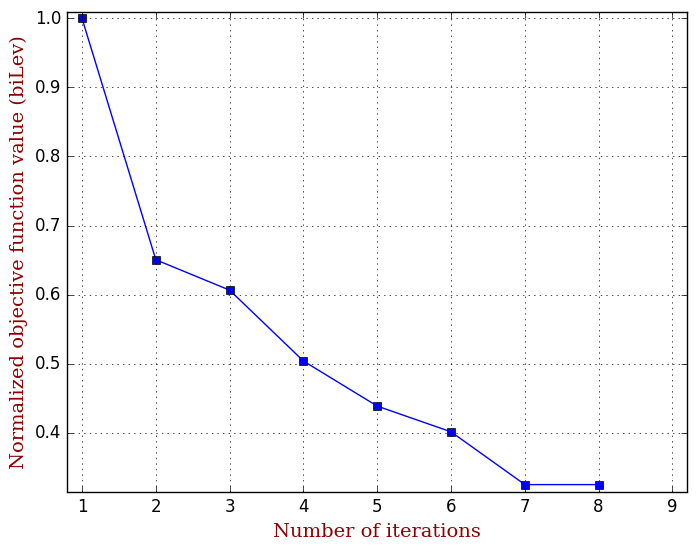

In [18]:
using PyPlot

iterNum = 1:(length(norObjFunDict))

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

PyPlot.plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(norObjFunDict) + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = Dict("family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14)

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_Sioux.pdf")

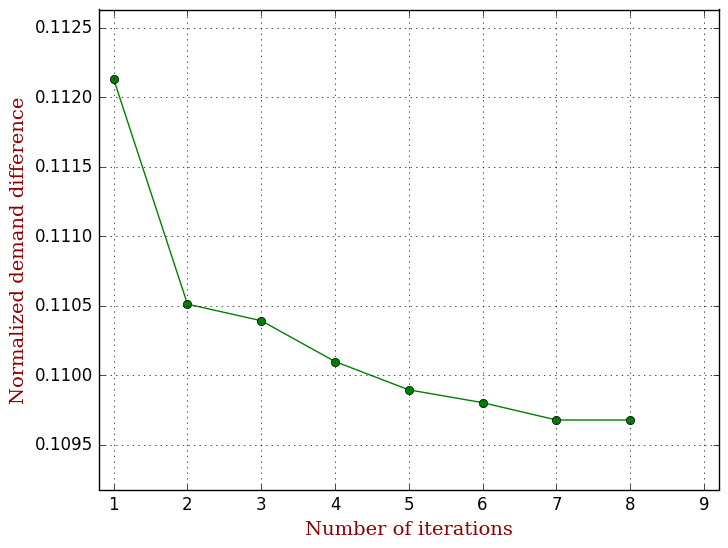

In [19]:
using PyPlot

iterNum = 1:(length(demandsDiffDict))

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

PyPlot.plot(iterNum, demandsDiff, "o-g")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, length(demandsDiffDict) + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = Dict("family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14)

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_Sioux.pdf")

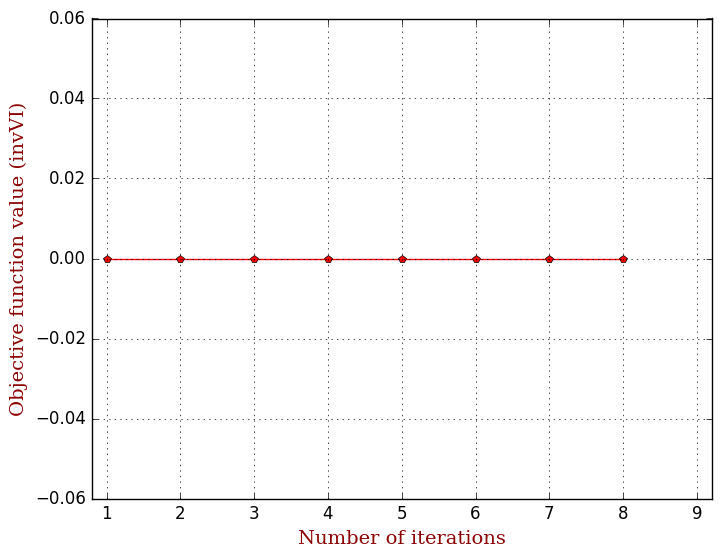

In [20]:
using PyPlot

iterNum = 1:(length(objInvVIDict))

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

PyPlot.plot(iterNum, objFun, "p-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, length(objInvVIDict) + 1 + .2)
# ylim(0.9, 2.0)

font1 = Dict("family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14)

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_Sioux.pdf")

In [21]:
coeffs_dict

Dict{Any,Any} with 8 entries:
  (6,3.41,1.0,1) => [1.0,0.0,0.0,0.0,0.15]
  (6,3.41,1.0,4) => [1.0,0.0,0.0,0.0,0.15]
  (6,3.41,1.0,2) => [1.0,0.0,0.0,0.0,0.15]
  (6,3.41,1.0,3) => [1.0,0.0,0.0,0.0,0.15]
  (6,3.41,1.0,5) => [1.0,0.0,0.0,0.0,0.15]
  (6,3.41,1.0,7) => [1.0,0.0,0.0,0.0,0.15]
  (6,3.41,1.0,8) => [1.0,0.0,0.0,0.0,0.15]
  (6,3.41,1.0,6) => [1.0,0.0,0.0,0.0,0.15]

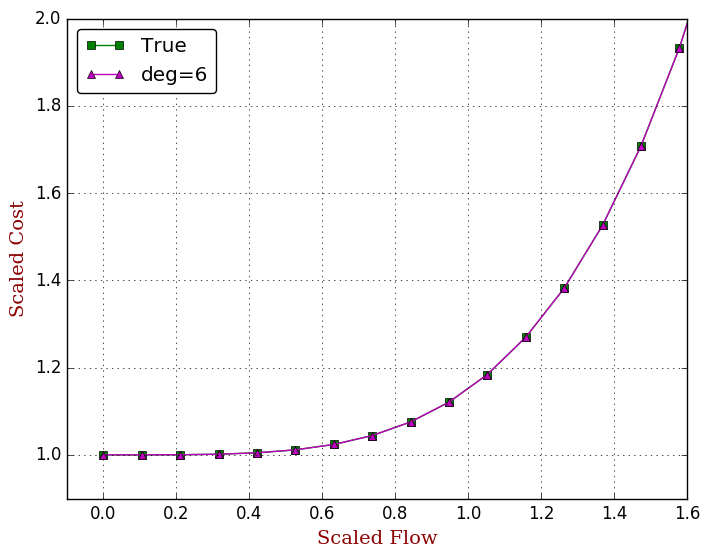

In [22]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

PyPlot.plot(xs, zs_true, "s-g", label="True")

PyPlot.plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = Dict("family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14)
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

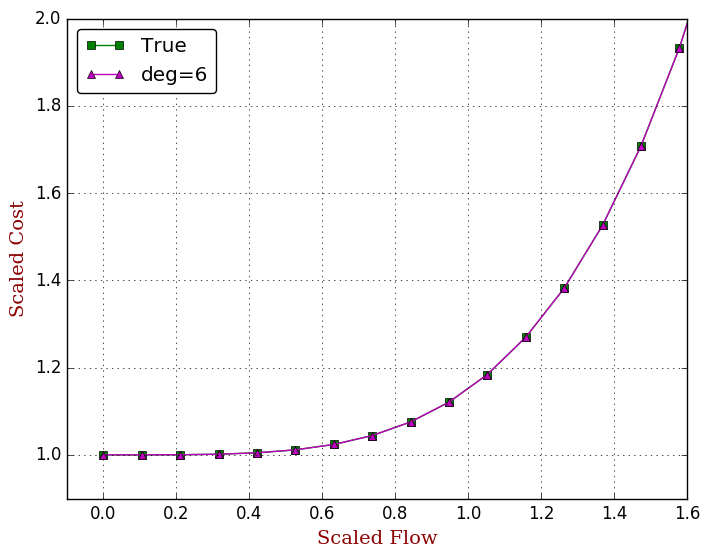

In [23]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

PyPlot.plot(xs, zs_true, "s-g", label="True")

PyPlot.plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = Dict("family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14)
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

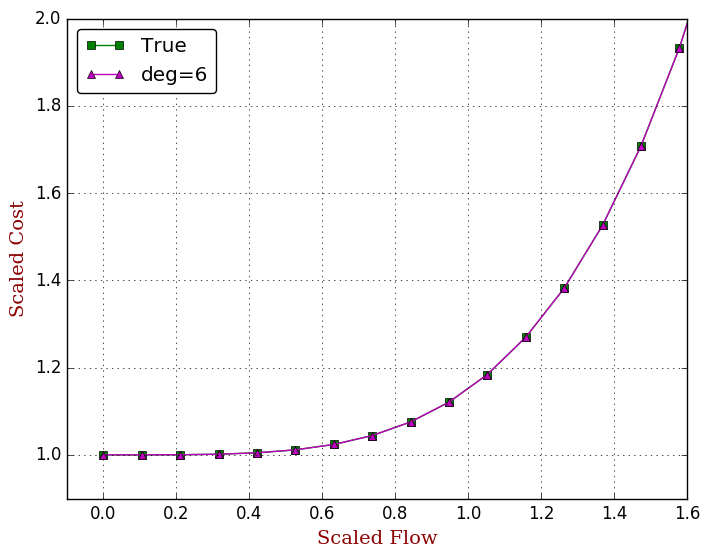

In [24]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

PyPlot.plot(xs, zs_true, "s-g", label="True")

PyPlot.plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = Dict("family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14)
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

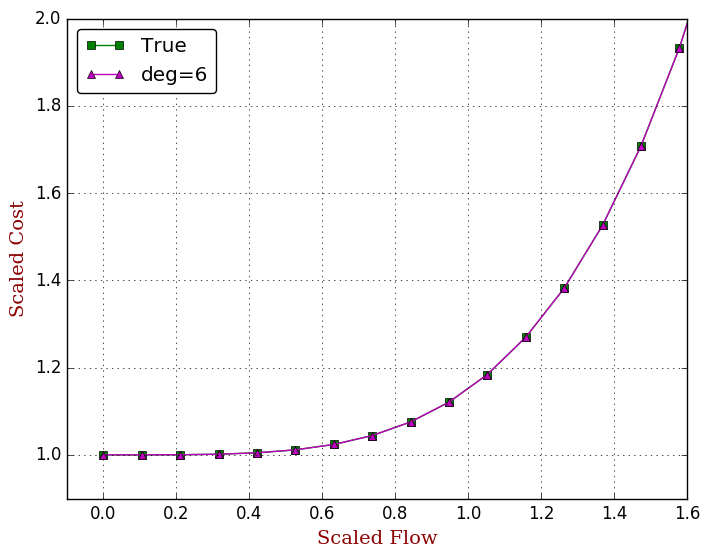

In [25]:
using PyPlot

iterN = length(coeffs_dict)

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

PyPlot.plot(xs, zs_true, "s-g", label="True")

PyPlot.plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = Dict("family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14)
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

In [26]:
outfile = open("./results/norObjFunDict.json", "w")

JSON.print(outfile, norObjFunDict)

close(outfile)

In [27]:
outfile = open("./results/demandsDiffDict.json", "w")

JSON.print(outfile, demandsDiffDict)

close(outfile)

In [28]:
outfile = open("./results/objInvVIDict.json", "w")

JSON.print(outfile, objInvVIDict)

close(outfile)

In [29]:
outfile = open("./results/coeffs_dict.json", "w")

JSON.print(outfile, coeffs_dict)

close(outfile)

In [30]:
outfile = open("./results/demandsVecDict.json", "w")

JSON.print(outfile, demandsVecDict)

close(outfile)

In [31]:
outfile = open("./results/demandsDict.json", "w")

JSON.print(outfile, demandsDict)

close(outfile)

In [32]:
outfile = open("./results/tapFlowDicDict.json", "w")

JSON.print(outfile, tapFlowDicDict)

close(outfile)